In [1]:
# IMPORTS
import psutil
import re
import os
import numpy as np
import time
import tensorflow as tf
import datetime
import matplotlib.pyplot as plt
import sys
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU
from keras.callbacks import ModelCheckpoint
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.utils import Sequence
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from keras import backend as K
import math
from collections import Counter

In [2]:
#DIRECTORIES
DATASET = "../input/harry-potter-gru-text-generator"
DATA_PATH = "../input/harry-potter-philosophers-stone-preprocessed/Harry_Potter_philosophers_stone.txt"
SAVED_MODEL_PATH = "../input/harry-potter-gru-text-generator/Best_weights.hdf5"
CHECKPOINT_PATH = "Best_weights.hdf5"

In [ ]:
#Copy file from Input to Output(to easier create a new dataset with updated weights)
for file in os.listdir(DATASET):
    if file.endswith('hdf5') == False:
        path = os.path.join(DATASET, file)
        !cp -r $path ./

In [3]:
#Load the file
text = open(DATA_PATH, "r", encoding="utf-8").read().lower()
words = text.split()

In [48]:
#How many unique words
words_unique = Counter(words).most_common()
dictionary = {}
for word in words_unique:
    dictionary[word[0]] = word[1]
dict_values = list(dictionary.values())

In [38]:
#trying to remove sentences with low usage words.
words_remove = [list(dictionary.keys())[idx] for idx, val in enumerate(dict_values) if val <= 3 and len(list(dictionary.keys())[idx]) >= 3]
print(len(words_remove))
sentences = re.split('[.!?]', text)
sent = []
sent = [re.sub('[\n]', '', sentence) for sentence in sentences]
sentences = [sentence for sentence in sent if not any(word in sentence for word in words_remove)]
print(len(sentences))

3938


In [ ]:
#text preprocessing
endings  = ('.', '!', '?')

for idx, word in enumerate(words):
    if word.endswith(endings) and word not in endings:
        words[idx] = re.sub('[.!?]', '', word)
        words.insert(idx+1, word[-1])
    if words[idx].startswith('.') and word not in endings:
        words[idx] = re.sub('[.]', '', word)
        words.insert(idx-1, '.')
    if re.search('.[.].', words[idx]):
        w = word.split('.')
        words[idx] = '.'
        words.insert(idx-1, w[0])
        words.insert(idx+1, w[-1])
text = ' '.join(words)

#How many unique words
words_unique = Counter(words).most_common()
dictionary = {}
for word in words_unique:
    dictionary[word[0]] = word[1]
dict_values = list(dictionary.values())

In [47]:
new_text = ''.join(sentences)
new_text = re.sub('  ', ' ', new_text)
words = new_text.split()

979


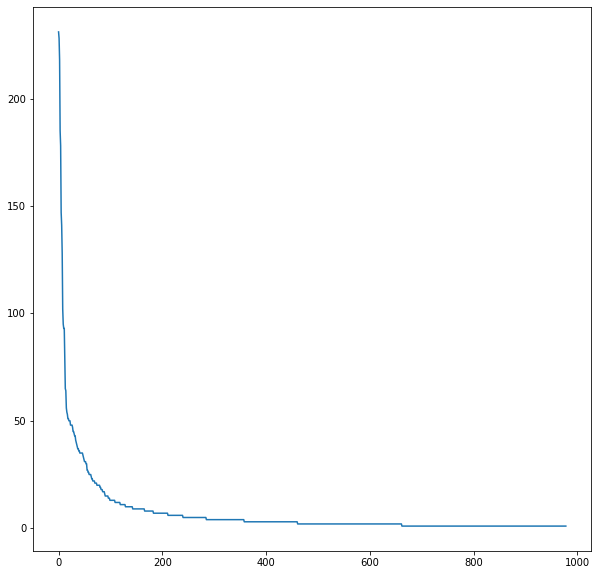

In [49]:
print(len(words_unique))
plt.figure(figsize=(10,10))
plt.plot(dict_values)
plt.show()

In [50]:
#DATA PREPERATION
LEN_SEQUENCE = 3

#Creating generator
class data_sequence(Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]

        return batch_x, batch_y

#OPEN DATA
#text = open(DATA_PATH, "r", encoding="utf-8").read().lower()

#DATA PREPARATION
WORDS_IN_TEXT = len(words)
ALL_WORDS = sorted(set(words))

word_to_int = {word:i for i, word in enumerate(ALL_WORDS)}
int_to_word = {v: k for k, v in word_to_int.items()}

X = []
y = []

perc = [per for per in range(10, 101, 10)]
j = 0

for i in range(0, WORDS_IN_TEXT-LEN_SEQUENCE, 1):
#     if i == int((WORDS_IN_TEXT-LEN_SEQUENCE-1) * perc[j] / 100):
#         print(f'{perc[j]}%')
#         j += 1
#         process = psutil.Process(os.getpid())
#         print(process.memory_info().rss / 2**20)  # in bytes 
    sequence_X = words[i:i+LEN_SEQUENCE]
    sequence_y = words[i+LEN_SEQUENCE]
    X.append([word_to_int[c] for c in sequence_X])
    y.append(word_to_int[sequence_y])   

patterns = len(X)
X_data = np.reshape(X, (patterns, LEN_SEQUENCE, 1))
# print('X_data_reshape')
# process = psutil.Process(os.getpid())
# print(process.memory_info().rss / 2**20)  # in bytes 
# X_data = X_data.astype("float32")
# print('X_data_float32')
# process = psutil.Process(os.getpid())
# print(process.memory_info().rss / 2**20)  # in bytes 
# X_data = X_data/float(len(ALL_WORDS))
# print('preproces')
# process = psutil.Process(os.getpid())
# print(process.memory_info().rss / 2**20)  # in bytes 
y_data = np_utils.to_categorical(y)

#Data split
val_samples = int(patterns * 0.80)
X_train = X_data[:val_samples, :, :]
X_test = X_data[val_samples:, :, :]
Y_train = y_data[:val_samples]
Y_test = y_data[val_samples:]

In [ ]:
#TRAINING PIPELINE (from weights)

#PARAMETERS
UNITS = 512
DROPOUT = 0.2
BATCH = 64
EPOCH = 1

#CHECKPOINT INITIALIZATION
checkpoint = ModelCheckpoint(CHECKPOINT_PATH, monitor='loss', verbose=1, save_best_only=True, mode='min')

#STOP TRAINING IF NO IMPROVE
#early_stop = tf.keras.callbacks.EarlyStopping("loss", patience=2, restore_best_weights=True)

#LOAD WEIGHTS(from dataset)
sequence = data_sequence(X_data, y_data, BATCH)
model = keras.models.load_model(SAVED_MODEL_PATH)
tensorboard_log = tf.keras.callbacks.TensorBoard(f"./logs/{datetime.datetime.now().strftime('%d-%m-%y-%H:%M')}-L:{LEN_SEQUENCE}_U:{UNITS}_D:{DROPOUT}_B:{BATCH}", histogram_freq=1)

#CHANGE lr
K.set_value(model.optimizer.learning_rate, 0.0001)

# START TREINING
model.fit(sequence, epochs=EPOCH, callbacks=[checkpoint, tensorboard_log])

In [56]:
#TRAIN FROM SCRATCH

#PARAMETERS
UNITS = 512
DROPOUT = 0.5
BATCH = 64
EPOCH = 100

#CREATE MODEL
model = Sequential()
model.add(GRU(UNITS, input_shape=(X_data.shape[1], X_data.shape[2]), return_sequences=True))
model.add(Dropout(DROPOUT))
model.add(GRU(UNITS))
model.add(Dropout(DROPOUT))
model.add(Dense(y_data.shape[1], activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam")

#CHECKPOINT INITIALIZATION
checkpoint = ModelCheckpoint(CHECKPOINT_PATH, monitor='loss', verbose=1, save_best_only=True, mode='min')

train_sequence = data_sequence(X_train, Y_train, BATCH)
test_sequence = data_sequence(X_test, Y_test, BATCH)
tensorboard_log = tf.keras.callbacks.TensorBoard(f"./logs/{datetime.datetime.now().strftime('%d-%m-%y-%H:%M')}-L:{LEN_SEQUENCE}_U:{UNITS}_D:{DROPOUT}_B:{BATCH}", histogram_freq=1)
model.fit(train_sequence, epochs=EPOCH, callbacks=[checkpoint, tensorboard_log], validation_data=test_sequence)

2022-09-07 19:12:23.947109: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-09-07 19:12:23.947329: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-09-07 19:12:23.947940: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/100
 2/92 [..............................] - ETA: 16s - loss: 6.8513 

2022-09-07 19:12:28.796192: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-09-07 19:12:28.796423: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-09-07 19:12:28.921139: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-09-07 19:12:28.928923: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-09-07 19:12:28.937877: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/07-09-22-19:12-L:3_U:512_D:0.5_B:64/train/plugins/profile/2022_09_07_19_12_28

2022-09-07 19:12:28.944457: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/07-09-22-19:12-L:3_U:512_D:0.5_B:64/train/plugins/profile/2022_09_07_19_12_28/bfdca412e011.trace.json.gz
2022-09-07 19:12:28.959361: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: .

92/92 [==============================] - 12s 80ms/step - loss: 6.1586 - val_loss: 5.8335

Epoch 00001: loss improved from inf to 6.15863, saving model to Best_weights.hdf5
Epoch 2/100
92/92 [==============================] - 6s 62ms/step - loss: 5.8809 - val_loss: 5.8662

Epoch 00002: loss improved from 6.15863 to 5.88092, saving model to Best_weights.hdf5
Epoch 3/100
92/92 [==============================] - 5s 58ms/step - loss: 5.8230 - val_loss: 5.8801

Epoch 00003: loss improved from 5.88092 to 5.82303, saving model to Best_weights.hdf5
Epoch 4/100
92/92 [==============================] - 5s 59ms/step - loss: 5.7845 - val_loss: 5.9240

Epoch 00004: loss improved from 5.82303 to 5.78454, saving model to Best_weights.hdf5
Epoch 5/100
92/92 [==============================] - 6s 61ms/step - loss: 5.7522 - val_loss: 5.8988

Epoch 00005: loss improved from 5.78454 to 5.75215, saving model to Best_weights.hdf5
Epoch 6/100
92/92 [==============================] - 6s 66ms/step - loss: 5.7229

In [ ]:
model.fit(train_sequence, epochs=100, callbacks=[checkpoint, tensorboard_log], validation_data=test_sequence)

Epoch 1/100
 2/92 [..............................] - ETA: 16s - loss: 4.1291

2022-09-07 19:32:07.388192: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-09-07 19:32:07.388446: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-09-07 19:32:07.504756: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-09-07 19:32:07.510449: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-09-07 19:32:07.516541: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/07-09-22-19:12-L:3_U:512_D:0.5_B:64/train/plugins/profile/2022_09_07_19_32_07

2022-09-07 19:32:07.519810: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/07-09-22-19:12-L:3_U:512_D:0.5_B:64/train/plugins/profile/2022_09_07_19_32_07/bfdca412e011.trace.json.gz
2022-09-07 19:32:07.533726: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: .

92/92 [==============================] - 6s 65ms/step - loss: 4.1442 - val_loss: 7.5573

Epoch 00001: loss did not improve from 4.13221
Epoch 2/100
92/92 [==============================] - 5s 58ms/step - loss: 4.1400 - val_loss: 7.5832

Epoch 00002: loss did not improve from 4.13221
Epoch 3/100
92/92 [==============================] - 5s 57ms/step - loss: 4.1299 - val_loss: 7.5785

Epoch 00003: loss improved from 4.13221 to 4.12987, saving model to Best_weights.hdf5
Epoch 4/100
92/92 [==============================] - 6s 65ms/step - loss: 4.1226 - val_loss: 7.6347

Epoch 00004: loss improved from 4.12987 to 4.12261, saving model to Best_weights.hdf5
Epoch 5/100
92/92 [==============================] - 5s 58ms/step - loss: 4.1228 - val_loss: 7.6493

Epoch 00005: loss did not improve from 4.12261
Epoch 6/100
92/92 [==============================] - 5s 57ms/step - loss: 4.0661 - val_loss: 7.6465

Epoch 00006: loss improved from 4.12261 to 4.06615, saving model to Best_weights.hdf5
Epoch 7

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

In [ ]:
Y_train[10]
_, counts = np.unique(Y_train[10], return_counts=True)
print(counts)
#Y_train[0]

In [ ]:
#parametr tunning with tensorboard

#PARAMETERS
EPOCHS = 5
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([256, 512]))
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.1, 0.2]))
HP_BATCH = hp.HParam('batch', hp.Discrete([32, 64]))
HP_TIME = hp.HParam('time')
HP_SEQUENCE = hp.HParam('Len_sequence')

#HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

#Directory to save logs
log_dir = "./logs/"

with tf.summary.create_file_writer(log_dir).as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_BATCH, HP_TIME, HP_SEQUENCE],
        metrics=[
        hp.Metric(tag="categorical_crossentropy", display_name="Loss")
        ]
    )
        
    
#defining model with changing parameters    
def train_test_model(hparams, directory):
    model = Sequential()
    model.add(LSTM(hparams[HP_NUM_UNITS], input_shape=(X_data.shape[1], X_data.shape[2]), return_sequences=True))
    model.add(Dropout(hparams[HP_DROPOUT]))
    model.add(LSTM(hparams[HP_NUM_UNITS]))
    model.add(Dropout(hparams[HP_DROPOUT]))
    model.add(Dense(y_data.shape[1], activation="softmax"))
    model.compile(
    optimizer="adam",
    loss='categorical_crossentropy'
    )
    sequence = data_sequence(X_data, y_data, hparams[HP_BATCH])
    start_time = time.time()
    history = model.fit(sequence, epochs=EPOCHS, callbacks=[tf.keras.callbacks.TensorBoard(f"{directory}:{batch_size}", histogram_freq=1)])
    duration = time.time() - start_time
    return history, duration

def run_experiment(directory, hparams):
    with tf.summary.create_file_writer(directory).as_default():
        hist, time = train_test_model(hparams, directory)
        hparams["time"] = (time)/EPOCHS
        hparams["Len_sequence"] = LEN_SEQUENCE
        hp.hparams(hparams)
        for step, loss in enumerate(hist.history["loss"]):
                tf.summary.scalar("categorical_crossentropy", loss, step=step)

session_num = 0

#training loop
for num_units in HP_NUM_UNITS.domain.values:
    for dropout_rate in HP_DROPOUT.domain.values:
        for batch_size in HP_BATCH.domain.values:
            hparams = {
                HP_NUM_UNITS: num_units,
                HP_DROPOUT: dropout_rate,
                HP_BATCH: batch_size
                }
            run_name = "/run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            run_experiment(log_dir+run_name, hparams)
            
            session_num += 1

In [ ]:
#compress folder to zip file
import shutil
shutil.make_archive("tensorboard", 'zip', "./logs")

In [57]:
#GENERATE TEXT

#Load model
#SAVED_MODEL_PATH = '../input/harry-potter-gru-text-generator/Best_weights.hdf5'
#model = keras.models.load_model(SAVED_MODEL_PATH)
#model.compile(loss='categorical_crossentropy', optimizer='adam')

# Function which make our output more random
def temp_index(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds[0], 1)
    return np.argmax(probas)

start = np.random.randint(0, len(X)-1)
start = 70
pattern = X[start]
pred_text = []
print("Seed:")
print("\"", ' '.join([int_to_word[value] for value in pattern]), "\"")
print("")
#LOWER VALUE-MORE GENERIC/REPETITIVE/PREDICTIVE TEXT : HIGHER VALUE-MORE SUPRISING/UNPREDICTABLE TEXT
temperature = 1
for i in range(120):
    x = np.reshape(pattern, (1, len(pattern), 1))
    x = x / float(len(ALL_WORDS))
    prediction = model.predict(x, verbose=0)
    index = temp_index(prediction, temperature)
    result = int_to_word[index]
    seq_in = [int_to_word[value] for value in pattern]
    pred_text.append(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]
print(' '.join(pred_text))    
print("\nDone.")

Seed:
" around the corner night "

knew knew knew centaurs bit unusual centaurs coming unusual knew quick knew knew knew bit notice knew centaurs knew bit knew knew bit pockets knew better truth crabbe leaky about knew knew teach anyway breakfast knew knew unusual supposed knew knew knew knew knew coming knew isnt knew crabbe knew useful whos air waving knew knew knew knew knew cause knew draco quick smell knew knew centaurs knew warning unusual c knew bit knew knew centaurs send knew knew knew unusual minute library knew knew knew knew knew anyway hold knew cause half knew bit wonder knew unusual his knew knew knew centaurs knew knew knew knew bit knew knew bit centaurs coming knew ourselves quick bear unusual knew knew

Done.


In [ ]:
SAVED_MODEL_PATH = './Best_weights.hdf5'
model = keras.models.load_model(SAVED_MODEL_PATH)

In [ ]:
#change LR
from keras import backend as K
print(model.optimizer.lr)
K.set_value(model.optimizer.learning_rate, 0.0001)
model.optimizer.lr